
# Campaign contribution of 2012 election

The data is obtained from fec, and here's a couple of things to do. 
1. Clean up the name of doner and emplyer of them. More information can be found in clean_up_name dict
2. Find the contribution for each occupation and for each party, and make a plot for major occupations.
3. Top donner for two candidates in 2012 (obama and romney), by state and by occupations


In [1]:
import pandas as pd 
fec = pd.read_csv('P00000001-ALL.csv', dtype={'contbr_zip':str})

cand = fec.cand_nm.unique().tolist()
dict_cand = {}
for c in cand:
    if c != 'Obama, Barack':
        dict_cand[c] = 'Republican'
    else:
        dict_cand[c] = 'Democrat'
fec['party'] = fec.cand_nm.map(dict_cand)
fec = fec[fec.contb_receipt_amt > 0]
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,368633403,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073,Republican
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073,Republican
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,719016467,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican


Here's the outline:
1. Use map function to add party affiliation. (Everyone is Republican except for Barack Obama. 
2. get number of contributions for each occupation.
3. Clean the occupation and employname
4. compare which occupation prefers which party 
5. generate plot for 4
6. get top donner for obama and romney by occupation/by state
7. use qcut to categorize the contribution amount.

## clean up occupation column

In [3]:
clean_up_name = {'INFORMATION REQUESTED PER BEST EFFORTS': 'NOT PROVIDED',
                 'INFORMATION REQUESTED': 'NOT PROVIDED',
                'INFORMATION REQUESTED (BEST EFFORTS)': 'NOT PROVIDED',
                 'C.E.O.': 'CEO'}

for k, v in clean_up_name.items():
    fec['contbr_occupation'] = fec.contbr_occupation.str.replace(k, v)
for k, v in clean_up_name.items():
    fec['contbr_employer'] = fec.contbr_employer.str.replace(k, v)

Alternatively, there's another way to replace these garbage names. However, we can not simply apply map function because if there is not a key there, the resulted value is going to be NA. Hence, we have to use get(x,x) to make x the default value, which means, allow occupations with no mapping to pass through. 

In [4]:
emp_mapping = {
       'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
       'INFORMATION REQUESTED' : 'NOT PROVIDED',
       'SELF' : 'SELF-EMPLOYED',
       'SELF EMPLOYED' : 'SELF-EMPLOYED',
}
f = lambda x: emp_mapping.get(x, x) #make sure understand the get function.
fec.contbr_employer.map(f)
fec.contbr_employer.head()

0         RETIRED
1         RETIRED
2    NOT PROVIDED
3            NONE
4            NONE
Name: contbr_employer, dtype: object

## top doner by occupation

In [5]:
amount_party_job = fec.groupby(['party', 'contbr_occupation']).sum()['contb_receipt_amt']
amount_party_job = amount_party_job.unstack(0)
sorting_idx = amount_party_job.sum(1).sort_values(ascending=False).index
sorting_idx = sorting_idx[0:10]
to_plot = amount_party_job.loc[sorting_idx, :] #it's a dataframe
to_plot.plot(kind='barh')

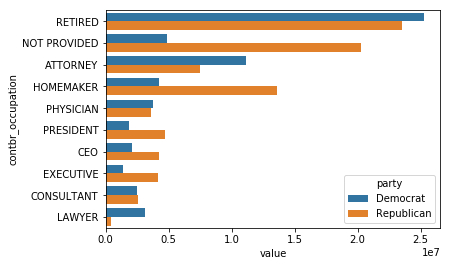

In [6]:
#an alternative way to make plots.
#the trick is make a designated column for party affiliation
import seaborn as sns 
sns_plot = to_plot.reset_index().melt(id_vars='contbr_occupation', value_vars=['Democrat', 'Republican'])
sns.barplot(data=sns_plot, hue='party', x='value', y='contbr_occupation')

## Top doners by candidates

In [7]:
two_cand = fec.loc[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt']), :]
two_cand.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party
411,C00431171,P80003353,"Romney, Mitt","ELDERBAUM, WILLIAM",DPO,AA,340230183,US GOVERNMENT,FOREIGN SERVICE OFFICER,25.0,01-FEB-12,NaN,NaN,NaN,SA17A,780124,Republican
412,C00431171,P80003353,"Romney, Mitt","ELDERBAUM, WILLIAM",DPO,AA,340230183,US GOVERNMENT,FOREIGN SERVICE OFFICER,110.0,01-FEB-12,NaN,NaN,NaN,SA17A,780124,Republican
413,C00431171,P80003353,"Romney, Mitt","CARLSEN, RICHARD",APO,AE,091280020,DEFENSE INTELLIGENCE AGENCY,INTELLIGENCE ANALYST,250.0,13-APR-12,NaN,NaN,NaN,SA17A,785689,Republican
414,C00431171,P80003353,"Romney, Mitt","DELUCA, PIERRE",APO,AE,091280005,CISCO,ENGINEER,30.0,21-AUG-11,NaN,NaN,NaN,SA17A,760261,Republican
415,C00431171,P80003353,"Romney, Mitt","SARGENT, MICHAEL",APO,AE,090120092,RAYTHEON TECHNICAL SERVICES CORP,COMPUTER SYSTEMS ENGINEER,100.0,07-MAR-12,NaN,NaN,NaN,SA17A,780128,Republican


In [8]:
def find_top_contrs(df):
    df = df.groupby('contbr_occupation').sum()['contb_receipt_amt']
    df = df.sort_values(ascending=False) #series sort values does not to pass anything...
    return df[0:5]

In [9]:
result_two_cand = two_cand.groupby(['cand_nm']).apply(find_top_contrs)
result_two_cand

cand_nm        contbr_occupation
Obama, Barack  RETIRED              25305116.38
               ATTORNEY             11141982.97
               NOT PROVIDED          4866973.96
               HOMEMAKER             4248875.80
               PHYSICIAN             3735124.94
Romney, Mitt   RETIRED              11508473.59
               NOT PROVIDED         11396894.84
               HOMEMAKER             8147446.22
               ATTORNEY              5364718.82
               PRESIDENT             2491244.89
Name: contb_receipt_amt, dtype: float64

In [10]:
def find_top_employer(df):
    df = df.groupby('contbr_employer').sum()['contb_receipt_amt']
    df = df.sort_values(ascending=False) #series sort values does not to pass anything...
    return df[0:10]

In [11]:
result_two_cand = two_cand.groupby(['cand_nm']).apply(find_top_employer)
result_two_cand

cand_nm        contbr_employer   
Obama, Barack  RETIRED               22694358.85
               SELF-EMPLOYED         17080985.96
               NOT EMPLOYED           8586308.70
               NOT PROVIDED           5053480.37
               HOMEMAKER              2605408.54
               SELF                   1076531.20
               SELF EMPLOYED           469290.00
               STUDENT                 318831.45
               VOLUNTEER               257104.00
               MICROSOFT               215585.36
Romney, Mitt   NOT PROVIDED          12059527.24
               RETIRED               11506225.71
               HOMEMAKER              8147196.22
               SELF-EMPLOYED          7409860.98
               STUDENT                 496490.94
               CREDIT SUISSE           281150.00
               MORGAN STANLEY          267266.00
               GOLDMAN SACH & CO.      238250.00
               BARCLAYS CAPITAL        162750.00
               H.I.G. CAPITAL      

The importand lesson learned here, is we can perform a groupby operation inside a groupby. In this case, for each presidnetial condidate, we groupby the occupations of their doner and find the top occupations/employers.

In [12]:
def find_top_state(df):
    df = df.groupby('contbr_st').sum()['contb_receipt_amt']
    df = df.sort_values(ascending=False) #series sort values does not to pass anything...
    return df
result_two_cand = two_cand.groupby(['cand_nm']).apply(find_top_state)
result_two_cand.head()

cand_nm        contbr_st
Obama, Barack  CA           23824984.24
               IL           16443895.84
               NY           14651918.51
               FL            7318178.58
               MA            6649015.25
Name: contb_receipt_amt, dtype: float64

In [13]:
two_cand_by_state = result_two_cand.unstack(0).dropna()
index = two_cand_by_state.sum(1).sort_values(ascending=False)[0:20].index #get top doner states
two_cand_by_state.div(two_cand_by_state.sum(1).values, axis=0).loc[index, :] #just get the ratio split, order by amount

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
CA,0.679498,0.320502
NY,0.589944,0.410056
IL,0.819226,0.180774
FL,0.467417,0.532583
TX,0.513634,0.486366
MA,0.585323,0.414677
VA,0.551400,0.448600
NJ,0.490051,0.509949
MD,0.747355,0.252645


# Bucketing Donation Amounts

This part is about bucketing or dicretizing the continuous variables into buckets. The most commonly used are the qcut function and cut function. The first one let you cut threshod while the second function gauretees that you can always have a equal sample size. 

In [14]:
import numpy as np
bins = np.array([0, 1, 10, 100, 1000, 10000,100000, 1000000, 10000000])
two_cand['bins'] = pd.cut(two_cand.contb_receipt_amt, bins)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
two_c = two_cand.groupby(['cand_nm', 'bins']).count()['contb_receipt_amt']
two_c
#you can treat this kind of variable as if it is a categorical one..

cand_nm        bins               
Obama, Barack  (0, 1]                    493.0
               (1, 10]                 40070.0
               (10, 100]              372280.0
               (100, 1000]            153991.0
               (1000, 10000]           22284.0
               (10000, 100000]             2.0
               (100000, 1000000]           3.0
               (1000000, 10000000]         4.0
Romney, Mitt   (0, 1]                     77.0
               (1, 10]                  3681.0
               (10, 100]               31853.0
               (100, 1000]             43357.0
               (1000, 10000]           26186.0
               (10000, 100000]             1.0
               (100000, 1000000]           NaN
               (1000000, 10000000]         NaN
Name: contb_receipt_amt, dtype: float64

In [17]:
two_c_prop = two_cand.groupby(['cand_nm', 'bins']).sum()['contb_receipt_amt'].unstack(0)
pp = two_c_prop.div(two_c_prop.sum(1), axis=0)

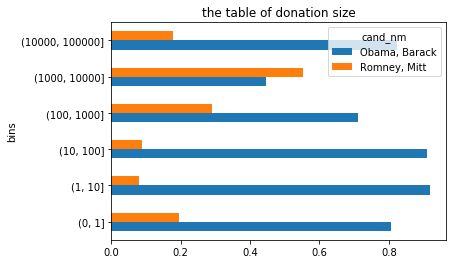

In [18]:
pp[0:-2].plot.barh(title='the table of donation size')